In [4]:
#!pip3 install torch

     |████████████████████████████████| 831.4 MB 2.0 kB/s eta 0:00:01    |▉                               | 20.4 MB 678 kB/s eta 0:19:56     |█▌                              | 38.2 MB 791 kB/s eta 0:16:42     |██▋                             | 66.7 MB 471 kB/s eta 0:27:03     |██████                          | 155.6 MB 446 kB/s eta 0:25:15     |████████▊                       | 227.7 MB 974 kB/s eta 0:10:20     |███████████                     | 283.0 MB 790 kB/s eta 0:11:34     |██████████████▊                 | 382.2 MB 941 kB/s eta 0:07:58     |████████████████                | 415.0 MB 811 kB/s eta 0:08:34     |██████████████████▌             | 480.2 MB 791 kB/s eta 0:07:24     |███████████████████▊            | 513.0 MB 983 kB/s eta 0:05:24


In [5]:
#!pip3 install torchvision

     |████████████████████████████████| 22.1 MB 197 kB/s  eta 0:00:01


In [2]:
!pip3 uninstall -y iglu && pip3 install git+https://github.com/iglu-contest/iglu.git

Found existing installation: iglu 0.2.2
Uninstalling iglu-0.2.2:
  Successfully uninstalled iglu-0.2.2
  Cloning https://github.com/iglu-contest/iglu.git to /tmp/pip-req-build-5m2s2_s4
  Running command git clone -q https://github.com/iglu-contest/iglu.git /tmp/pip-req-build-5m2s2_s4


  Created wheel for iglu: filename=iglu-0.2.2-py3-none-any.whl size=16227 sha256=a857a7decc8c09fedb4a74c3036c22896e2af680f9c7e27fe896e330a9ac1991
  Stored in directory: /tmp/pip-ephem-wheel-cache-dh2sz45u/wheels/b2/78/de/9361281dfe0286c1bef1a0d2925f099f64753327a0779e4561
Successfully built iglu


In [1]:
from iglu.tasks import TaskSet


/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from train import *

In [4]:
env.action_space

Discrete(18)

In [5]:
obs = env.reset()

/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/root/miniconda/envs/py37/lib/python3.7/runpy.py:125: RuntimeWarning: 'minerl_patched.utils.process_watcher' found in sys.modules after import of package 'minerl_patched.utils', but prior to execution of 'minerl_patched.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


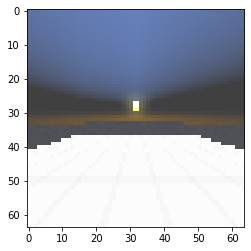

In [6]:
import matplotlib.pyplot as plt

plt.imshow(obs)

In [7]:
obs.shape

(64, 64, 3)

In [8]:
img = torch.tensor(obs.astype(float), dtype=torch.float).permute(2, 0, 1) 
imgs = img[None,:,:,:]

In [9]:
imgs = img[None,:,:,:]

In [10]:
result = policy_net(imgs)

In [11]:
result.max(1)[1].view(1, 1)

tensor([[1]])

In [13]:
EPS_END = 0.01

In [14]:
import random
import math

device = torch.device("cuda")


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], device=device, dtype=torch.long)

In [15]:
policy_net = DQN(num_actions)
target_net = DQN(num_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

policy_net.to(device)
target_net.to(device)

DQN(
  (visual_encoder): VisualEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (head): Linear(in_features=512, out_features=18, bias=True)
)

In [16]:
select_action(imgs)

tensor([[1]], device='cuda:0')

In [17]:
def optimize_model():
    if len(buffer) < BATCH_SIZE:
        return
    transitions = buffer.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [18]:
# set up matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

episode_durations = []
 
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
from itertools import count
from algorithms import *
from tqdm.notebook import tqdm

buffer = ReplayBuffer(10000)
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

num_episodes = 10000
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset()
    state = torch.tensor(state.astype(float), dtype=torch.float, device=device).permute(2, 0, 1)[None,:,:,:]
    for t in count():
        # Select and perform an action
        
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = torch.tensor(next_state.astype(float), dtype=torch.float, device=device).permute(2, 0, 1)[None,:,:,:]

        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        buffer.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


<Figure size 432x288 with 0 Axes>

/root/miniconda/envs/py37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


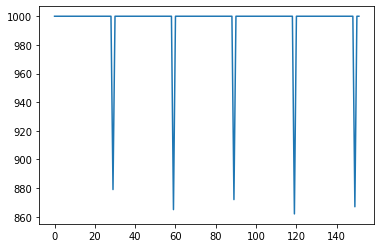

In [21]:
plt.plot(episode_durations)

In [52]:
eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
eps_threshold

0.01